In [1]:
%cd "StressDetector-EEG-v2/"

/workspaces/Project_StressDetection/StressDetector-EEG-v2


In [2]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
import torch
from src.utils.transforms import DeapAVToStress

from torcheeg.datasets.constants.emotion_recognition.deap import \
    DEAP_CHANNEL_LOCATION_DICT

dataset = DEAPDataset(
    io_path=f'../data_cache/deap',
    root_path='../DEAP/data_preprocessed_python-002/data_preprocessed_python',
    online_transform=transforms.Compose([
        transforms.To2d(),
        transforms.ToTensor()
    ]),
    label_transform=transforms.Compose([
        transforms.Select(['arousal','valence']),
        # transforms.Binary(5.0),
        # transforms.BinariesToCategory(),
        DeapAVToStress(thresholds=[
            [7.5, 2.5],
            [5.0, 5.0]]),
    ]),
    num_worker=8)

[2024-01-28 00:45:56] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../data_cache/deap.


In [3]:
train_val_test_split = [0.6, 0.2, 0.2]

train_size = int(train_val_test_split[0] * len(dataset))
val_size = int(train_val_test_split[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [4]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
)

In [5]:
from torch.optim import SGD, Adam
from mmengine.runner import Runner
from src.models.torcheeg_mmwraper import MMEEGNet
from src.utils.metrics import AccuracyWithLoss, Accuracy, ConfusionMatrix


runner = Runner(
    # the model used for training and validation.
    # Needs to meet specific interface requirements

    model=MMEEGNet(chunk_size=128,
                num_electrodes=32,
                dropout=0.5,
                kernel_1=64,
                kernel_2=16,
                F1=8,
                F2=16,
                D=2,
                num_classes=3).float(),

    # working directory which saves training logs and weight files
    work_dir='./.exp/new_deap_stress/eegnet',
    
    # train dataloader needs to meet the PyTorch data loader protocol
    train_dataloader=train_loader,
    # optimize wrapper for optimization with additional features like
    # AMP, gradtient accumulation, etc
    optim_wrapper=dict(optimizer=dict(type=Adam, 
                                      lr=0.001,
                                      betas=(0.9, 0.999),
                                      eps=1e-08)),
    # trainging coinfs for specifying training epoches, verification intervals, etc
    train_cfg=dict(by_epoch=True, 
                   max_epochs=200, 
                   val_interval=1),
    
    
    # validation dataloader also needs to meet the PyTorch data loader protocol
    val_dataloader=val_loader,
    # validation configs for specifying additional parameters required for validation
    val_cfg=dict(),
    # validation evaluator. The default one is used here
    val_evaluator=dict(type=AccuracyWithLoss),

    # test dataloader also needs to meet the PyTorch data loader protocol
    test_dataloader=test_loader,
    # test configs for specifying additional parameters required for testing
    test_cfg=dict(),
    # test evaluator. The default one is used here
    test_evaluator=[dict(type=Accuracy), dict(type=ConfusionMatrix, num_classes=3)],

    visualizer=dict(type='Visualizer', vis_backends=[dict(type='TensorboardVisBackend')]),
    
    resume=True,
)

01/28 00:45:58 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 1108086064
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.1.2+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-ge

In [6]:
runner.train()

01/28 00:45:58 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in visualizer will be None.
01/28 00:45:58 - mmengine - WARNING - The prefix is not set in metric class AccuracyWithLoss.
01/28 00:45:58 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in evaluator, metric and visualizer will be None.
Did not find last_checkpoint to be resumed.
01/28 00:45:58 - mmengine - INFO - Auto resumed from the latest checkpoint None.
01/28 00:45:58 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
01/28 00:45:58 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
01/28 00:45:58 - mmengine - INFO - Checkpoints will be saved to /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnet.
01/28 00:45:58 - mmengine - INFO - Epoch(train)   [1][ 10/720]  lr: 1.00

2024-01-28 00:45:58.907486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 00:45:59.013376: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 00:45:59.017502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-

01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 20/720]  lr: 1.0000e-03  eta: 3:21:52  time: 0.1217  data_time: 0.1163  memory: 41  loss: 1.0688


2024-01-28 00:45:59.829472: W tensorflow/c/logging.cc:37] Could not load dynamic library 'libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so'; dlerror: libd3d12.so: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-01-28 00:45:59.829523: W tensorflow/c/logging.cc:37] Could not load DirectML.
2024-01-28 00:45:59.829526: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 0 compatible adapters.


01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 30/720]  lr: 1.0000e-03  eta: 2:20:09  time: 0.0070  data_time: 0.0022  memory: 41  loss: 1.0519
01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 40/720]  lr: 1.0000e-03  eta: 1:48:59  time: 0.0065  data_time: 0.0020  memory: 41  loss: 1.0260
01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 50/720]  lr: 1.0000e-03  eta: 1:30:12  time: 0.0063  data_time: 0.0021  memory: 41  loss: 1.0103
01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 60/720]  lr: 1.0000e-03  eta: 1:17:36  time: 0.0061  data_time: 0.0017  memory: 41  loss: 0.9875
01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 70/720]  lr: 1.0000e-03  eta: 1:08:44  time: 0.0065  data_time: 0.0023  memory: 41  loss: 0.9465
01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 80/720]  lr: 1.0000e-03  eta: 1:01:57  time: 0.0060  data_time: 0.0019  memory: 41  loss: 0.9288
01/28 00:46:00 - mmengine - INFO - Epoch(train)   [1][ 90/720]  lr: 1.0000e-03  eta: 0:5

MMEEGNet(
  (data_preprocessor): BaseDataPreprocessor()
  (eegnet): EEGNet(
    (block1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
      (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Conv2dWithConstraint(8, 16, kernel_size=(32, 1), stride=(1, 1), groups=8, bias=False)
      (3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (6): Dropout(p=0.5, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
      (5): Dro

In [7]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


In [8]:
# Run trained model on test set
test_results = runner.test()

01/28 01:07:24 - mmengine - WARNING - The prefix is not set in metric class Accuracy.
01/28 01:07:24 - mmengine - INFO - Auto resumed from the latest checkpoint /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnet/epoch_200.pth.
Loads checkpoint by local backend from path: /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnet/epoch_200.pth
01/28 01:07:24 - mmengine - INFO - Load checkpoint from /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/eegnet/epoch_200.pth
01/28 01:07:24 - mmengine - WARNING - `resume_param_scheduler` is True but `self.param_schedulers` is None, so skip resuming parameter schedulers
01/28 01:07:24 - mmengine - INFO - resumed epoch: 200, iter: 144000
01/28 01:07:25 - mmengine - INFO - Epoch(test) [ 10/240]    eta: 0:00:02  time: 0.0121  data_time: 0.0076  memory: 33  
01/28 01:07:25 - mmengine - INFO - Epoch(test) [ 20/240]    eta: 0:00:02  time: 0.0064  data_time: 0.00

In [9]:
test_results

{'accuracy': tensor(77.9622),
 'confusion_matrix/result': tensor([[11835,    15,     0],
         [ 2946,   139,     0],
         [  423,     1,     1]])}

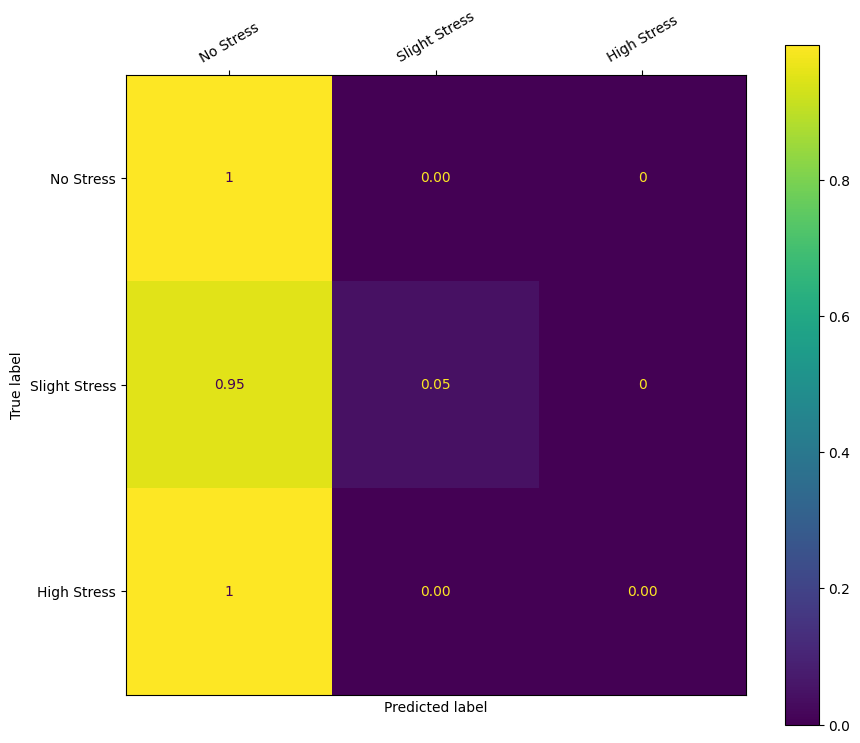

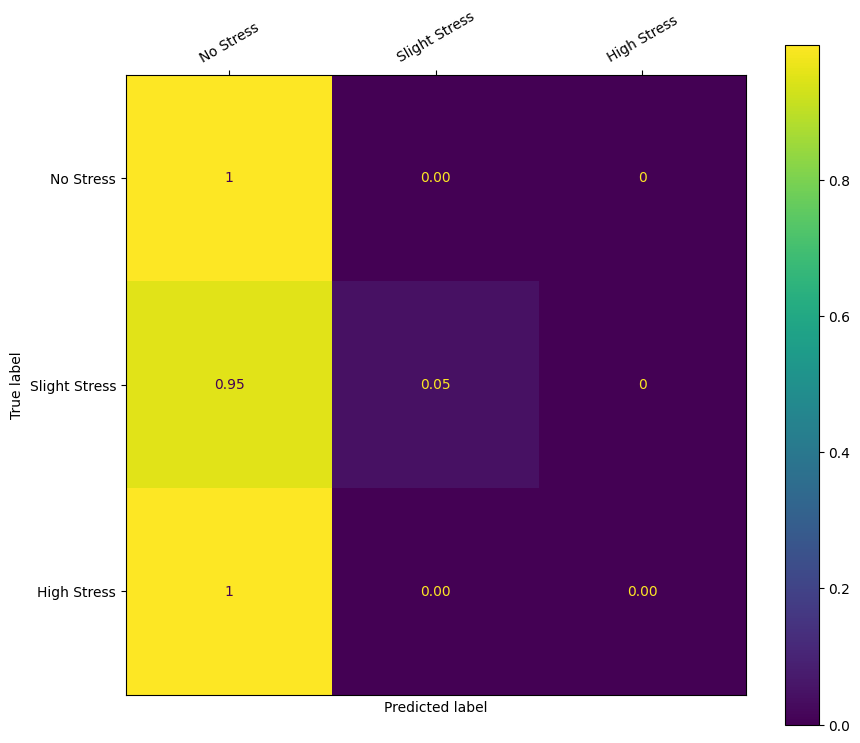

In [10]:
ConfusionMatrix().plot(test_results['confusion_matrix/result'], classes=['No Stress', 'Slight Stress', 'High Stress'], include_values=True, normalize=True)